# <center> Практика. Статистические тесты в контексте EDA

## Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

### В процессе анализа вы должны ответить на ключевые вопросы HR-агентства:

- Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
- Какие факторы влияют на зарплату у специалистов Data Scientist?
- Как соотносятся зарплаты Data Scientist и Data Engineer в различных компаниях?
- Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

Оригинальный датасет: “Data Science Job Salaries” (kaggle.com)

Таблица:
- work_year	Год, в котором была выплачена зарплата.

- experience_level	Опыт работы на этой должности в течение года со следующими возможными значениями:\
EN — Entry-level/Junior;\
MI — Mid-level/Intermediate;\
SE — Senior-level/Expert;\
EX — Executive-level/Director.

- employment_type	Тип трудоустройства для этой роли:\
PT — неполный рабочий день;\
FT — полный рабочий день;\
CT — контракт;\
FL — фриланс.

- job_title	Роль, в которой соискатель работал в течение года.

- salary	Общая выплаченная валовая сумма заработной платы.

- salary_currency	Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.

- salary_in_usd	Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).

- employee_residence	Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.

- remote_ratio	Общий объём работы, выполняемой удалённо. Возможные значения:\
0 — удалённой работы нет (менее 20 %);\
50 — частично удалённая работа;\
100 — полностью удалённая работа (более 80 %).

- company_location	Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.

- company_size	Среднее количество людей, работавших в компании в течение года:\
S — менее 50 сотрудников (небольшая компания);\
M — от 50 до 250 сотрудников (средняя компания);\
L — более 250 сотрудников (крупная компания).

## Загрузка данных

In [1]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

In [2]:
# загружаем датасет
data = pd.read_csv('data\ds_salaries.csv')
data.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [3]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


## Описательный анализ данных

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


В датасете 607 записей (без пропущенных значений).

Проверим данные на наличие полных дубликатов:

In [5]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

Количество дубликатов: 0


Дубликатов нет

### Визуальный анализ 
Распределение страховых выплат по всем клиентам

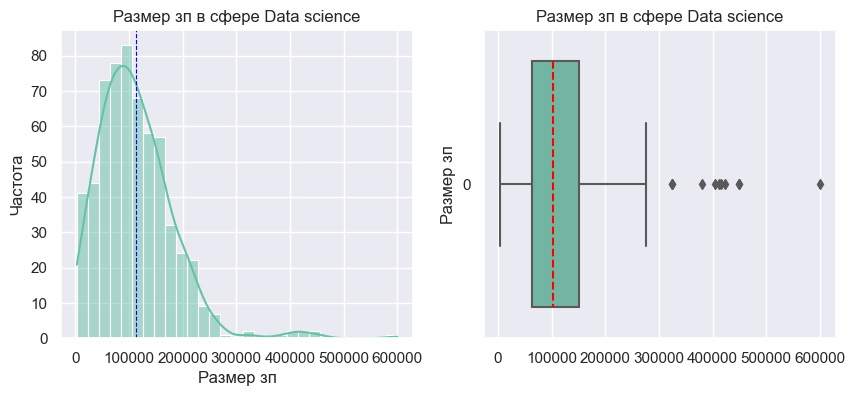

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4)) # 1 и 2 - это количество графиков по осям y и x 

sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Размер зп', ylabel='Частота')
axes[0].set_title('Размер зп в сфере Data science')
axes[0].axvline(data['salary_in_usd'].mean(), color='blue', linestyle='--', linewidth=0.8) # отражает среднее

sns.boxplot(data['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'}) # отражает медиану и межквартильный размах
axes[1].set(ylabel='Размер зп')
axes[1].set_title('Размер зп в сфере Data science')

plt.show()

# распределение далеко от нормального, смещено в сторону мелких значений влево

Распределение далеко от нормального, смещено влево. Есть незначительные выбросы

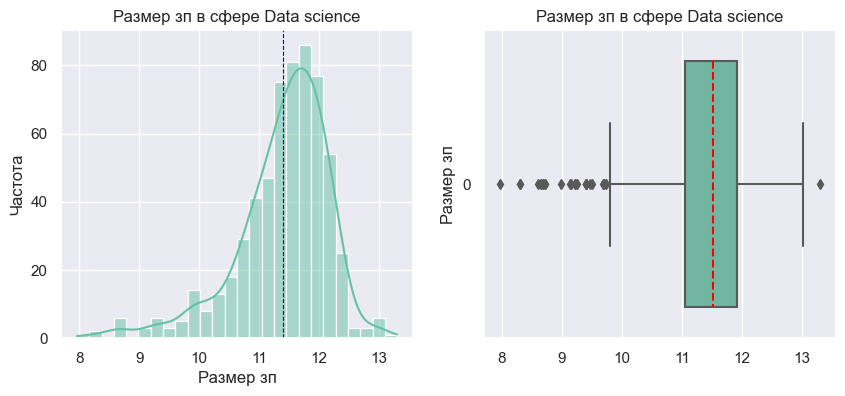

In [7]:
log_salary = np.log(data['salary_in_usd'])

fig, axes = plt.subplots(1, 2, figsize=(10, 4)) # 1 и 2 - это количество графиков по осям y и x 

sns.histplot(log_salary, kde=True, ax=axes[0])
axes[0].set(xlabel='Размер зп', ylabel='Частота')
axes[0].set_title('Размер зп в сфере Data science')
axes[0].axvline(log_salary.mean(), color='blue', linestyle='--', linewidth=0.8) # отражает среднее

sns.boxplot(log_salary, ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'}) # отражает медиану и межквартильный размах
axes[1].set(ylabel='Размер зп')
axes[1].set_title('Размер зп в сфере Data science')

plt.show()

Логарифмирование также не позволило добиться нормального распределения, работаем с исходными данными

In [8]:
data_agg = data['salary_in_usd'].describe().round(2).to_frame()
data_agg.columns = ['Размер зп']
data_agg

,Размер зп
count,607.00
mean,112297.87
std,70957.26
min,2859.00
25%,62726.00
50%,101570.00
75%,150000.00
max,600000.00


### Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

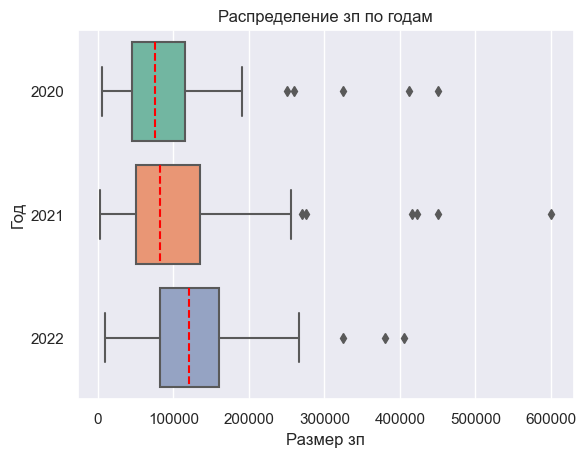

In [9]:
ax = sns.boxplot(data, x='salary_in_usd', y='work_year', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зп', ylabel='Год')
plt.title('Распределение зп по годам')
plt.show()

In [10]:
data_agg = data.groupby('work_year')['salary_in_usd'].describe().round(2)
print('ЗП по годам')
data_agg

ЗП по годам


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,72.0,95813.00,82831.80,5707.0,45724.5,75544.0,115526.0,450000.0
2021,217.0,99853.79,80225.11,2859.0,50000.0,82528.0,135000.0,600000.0
2022,318.0,124522.01,58183.65,10000.0,81666.0,120000.0,160000.0,405000.0


На первый взгляд зп в сфере увеличивается из года в год, но это без учета различных специальностей

In [11]:
import plotly.express as px

salary_year_job = data.pivot_table(
    values='salary_in_usd',
    index='work_year',
    columns='job_title',
    aggfunc = 'median',
    fill_value=0
)

#тепловая карта
fig = px.imshow(
    salary_year_job,
    aspect='auto',
    color_continuous_scale='greens',
    title='Медианная з/п из года в года в зависимости от вакансии'
)
fig.show()

Если посмотреть на все специальности по отдельности нельзя наверняка утверждать, что зп растет из года в год. Даже если не брать в расчет выбросы со свервысокой зп, и те вакансии, которые появились только в 2022 г., все равно мы не можем утверждать, что даже в половине вакансий идет постепенный рост из года в год.

### Какие факторы влияют на зарплату у специалистов Data Scientist?

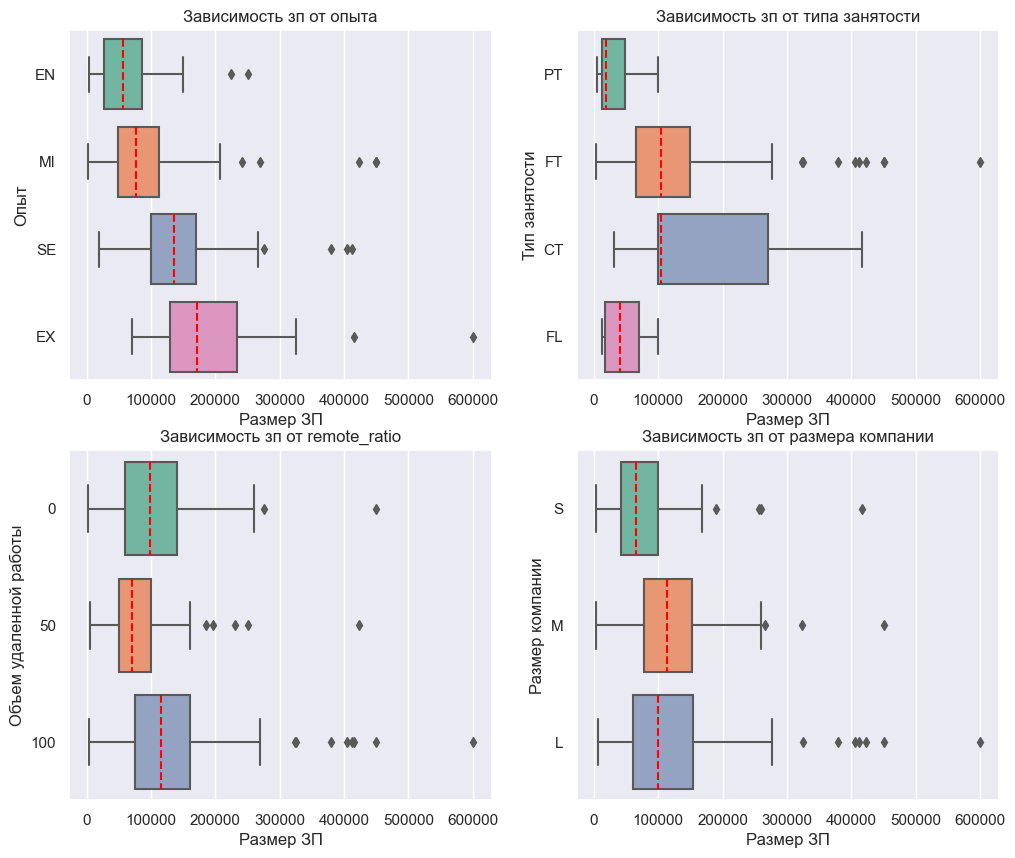

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10)) 

sns.boxplot(data, x='salary_in_usd', y='experience_level', ax=axes[0, 0], orient='h', order=('EN', 'MI', 'SE', 'EX'), medianprops={"color": "red", "linestyle": '--'}) 
axes[0, 0].set(xlabel='Размер ЗП', ylabel='Опыт')
axes[0, 0].set_title('Зависимость зп от опыта')

sns.boxplot(data, x='salary_in_usd', y='employment_type', ax=axes[0, 1], orient='h', order=('PT', 'FT', 'CT', 'FL'),medianprops={"color": "red", "linestyle": '--'}) 
axes[0, 1].set(xlabel='Размер ЗП', ylabel='Тип занятости')
axes[0, 1].set_title('Зависимость зп от типа занятости')

sns.boxplot(data, x='salary_in_usd', y='remote_ratio', ax=axes[1, 0], orient='h', medianprops={"color": "red", "linestyle": '--'}) 
axes[1, 0].set(xlabel='Размер ЗП', ylabel='Объем удаленной работы')
axes[1, 0].set_title('Зависимость зп от remote_ratio')

sns.boxplot(data, x='salary_in_usd', y='company_size', ax=axes[1, 1], orient='h', order=('S', 'M', 'L'),medianprops={"color": "red", "linestyle": '--'}) 
axes[1, 1].set(xlabel='Размер ЗП', ylabel='Размер компании')
axes[1, 1].set_title('Зависимость зп от размера компании')

plt.show()


На первый взгляд есть зависимость от опыта: чем выше экспертность, тем в среднем на большую ЗП может претендовать участник. По типам занятости наблюдается взаимосвязь между неполным и полным рабочим днем - полный день явно оплачивается больше. У людей, работающих по контракту очень большой разброс в ЗП, а фриланс оплачивается на сопоставимом уровне с неполным днем. Между уровнем ЗП и объемом удаленной работы; и ЗП и размера компании - зависимости не наблюдаются.

### Влияет ли локация сотрудника (расположен он в одном и том же регионе, что и работодатель или нет) на его заработную плату?

Можно предположить, что если человек живет там же, где находится главный офис, то его ЗП может быть выше, поскольку компании не нужно релоцировать сотрудника, проверим это.

### Влияет ли локация сотрудника (расположен он в одном и том же регионе, что и работодатель или нет) на его объем удаленной работы?
С другой стороны, если компания и сотрудник не находятся в одном регионе, должен быть выше Remote-ration

In [13]:
# Добавим вспомогаетльный столбец на счет того, совпадают регионы или нет

data['equal_regions'] = (data['employee_residence'] == data['company_location'])


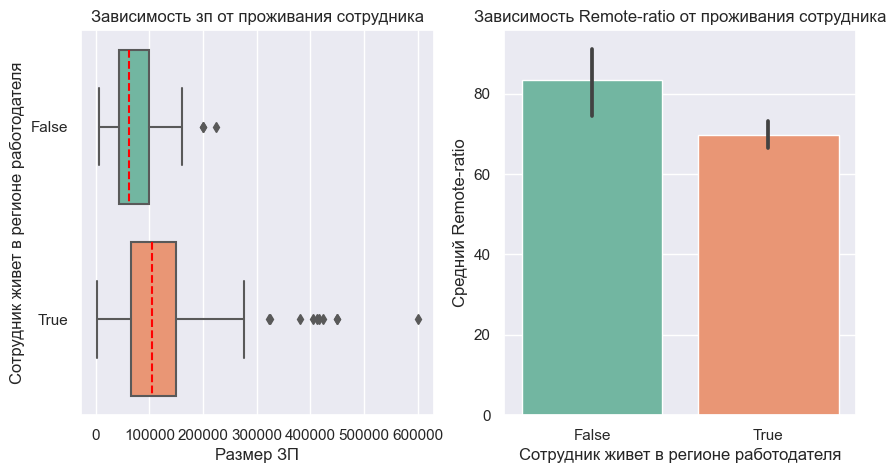

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5)) # 1 и 2 - это количество графиков по осям y и x 

sns.boxplot(data, x='salary_in_usd', y='equal_regions', ax=axes[0], orient='h', medianprops={"color": "red", "linestyle": '--'}) 
axes[0].set(xlabel='Размер ЗП', ylabel='Сотрудник живет в регионе работодателя')
axes[0].set_title('Зависимость зп от проживания сотрудника')

sns.barplot(data, y='remote_ratio', x='equal_regions', ax=axes[1]) 
axes[1].set(xlabel='Сотрудник живет в регионе работодателя', ylabel='Средний Remote-ratio')
axes[1].set_title('Зависимость Remote-ratio от проживания сотрудника')

plt.show()

Визуально можно сделать вывод, что Remote ratio действительно выше в случаях, когда головной офис компании и сотрудник находятся в разных регионах, т.е. человек по большей степени работает удаленно. Также кажется, что оплачивается удаленная работа из другого региона ниже, чем работа в том же городе.

### Как соотносятся зарплаты Data Scientist и Data Engineer в различных компаниях

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,equal_regions,job_classification
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L,True,Data Scientist
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S,True,Data Scientist
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M,True,Data Engineer
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S,True,other
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L,True,Data Engineer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,602,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,US,M,True,Data Engineer
603,603,2022,SE,FT,Data Engineer,126000,USD,126000,US,100,US,M,True,Data Engineer
604,604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M,True,other
605,605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M,True,other


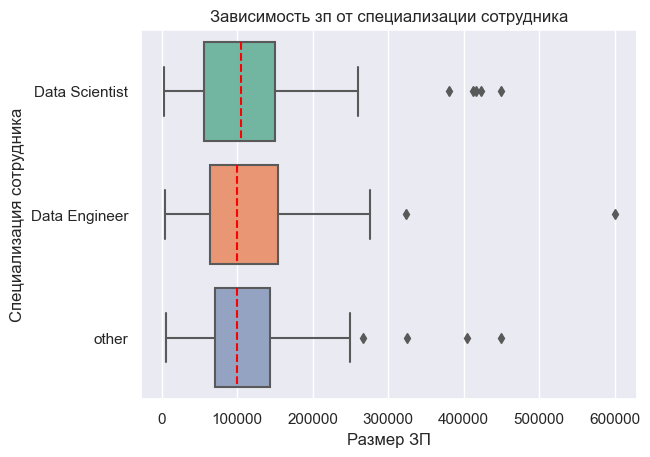

In [19]:
def separate_job(arg): 
    """
    separate jobs on Data Scientist, Data Engineer and other

    Args:
        arg (_str_): str of job

    Returns:
        str: Data Scientist, Data Engineer, other
    """    
    
    if ('Scientist' in arg):
        result = 'Data Scientist'
    elif ('Engineer' in arg):
        result = 'Data Engineer'
    else:
        result = 'other'
    return result    

data['job_classification'] = data['job_title'].apply(separate_job)
display(data)

ax = sns.boxplot(data, x='salary_in_usd', y='job_classification', orient='h', medianprops={"color": "red", "linestyle": '--'}) 
ax.set(xlabel='Размер ЗП', ylabel='Специализация сотрудника')
plt.title('Зависимость зп от специализации сотрудника')
plt.show()

In [21]:
data_agg = data.groupby('job_classification')['salary_in_usd'].describe().round(2)
print('Зависимость зп от специализации сотрудника')
data_agg

Зависимость зп от специализации сотрудника


,count,mean,std,min,25%,50%,75%,max
job_classification,,,,,,,,
Data Engineer,230.0,110870.99,69625.23,4000.0,63758.25,100000.0,154450.0,600000.0
Data Scientist,194.0,115202.26,77737.85,2859.0,56376.50,104945.0,150000.0,450000.0
other,183.0,111012.25,65141.96,5409.0,70326.50,100000.0,142923.0,450000.0


Нельзя напрямую сделать вывод, что ЗП Data Scientist, Data Engineer и других сотрудников сферы сильно отличается в зависимости от специальности

### Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

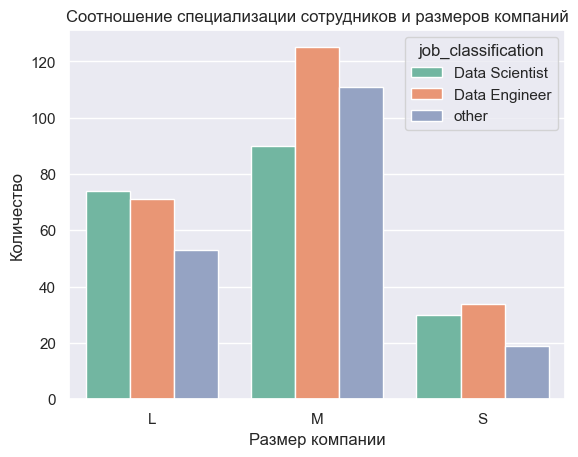

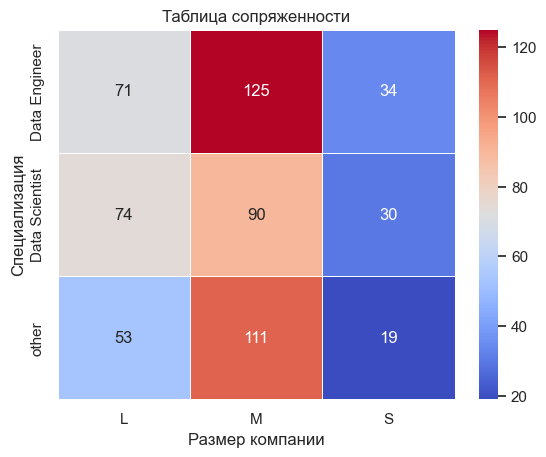

Зависимость специализации сотрудника от размера компании


,count,unique,top,freq
job_classification,,,,
Data Engineer,230,3,M,125
Data Scientist,194,3,M,90
other,183,3,M,111


In [33]:
ax = sns.countplot(data=data, x=data['company_size'], hue='job_classification', order=('L', 'M', 'S'))
ax.set(xlabel='Размер компании', ylabel='Количество')
plt.title('Соотношение специализации сотрудников и размеров компаний')
plt.show()

cross_tab = pd.crosstab(index=data['job_classification'], columns=data['company_size']) # таблица сопряженности
ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm") # тепловая карта
ax.set(xlabel='Размер компании', ylabel='Специализация')
plt.title('Таблица сопряженности')
plt.show()

data_agg = data.groupby('job_classification')['company_size'].describe().round(2)
print('Зависимость специализации сотрудника от размера компании')
data_agg

Согласно данным, можно предположить, что есть некоторая разница между размером компании и специализацией, но это вполне может быть погрешностью выборки, проверим на статистических тестах

## Статистический анализ данных



In [34]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы - по сути тоже самое, что и выше, но для всего остального кроме нормальности
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
      

### Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): Заработная плата (ЗП) в 2020 году ($μ_1$) статистически больше или равна ЗП 2021 ($μ_2$), а та больше или равна ЗП 2022 ($μ_3$).

$$ H_0 : μ_1 >= μ_2 >= μ_3$$

*Альтернативная гипотеза* ($H_1$): Заработная плата (ЗП) в 2020 году ($μ_1$) меньше ЗП 2021 ($μ_2$), и меньше ЗП 2022 ($μ_3$).

$$ H_1 : μ_1 < μ_2 < μ_3$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данных является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [42]:
# формируем группы
salary_2020 = data.loc[data['work_year']==2020, 'salary_in_usd'] 
salary_2021 = data.loc[data['work_year']==2021, 'salary_in_usd'] 
salary_2022 = data.loc[data['work_year']==2022, 'salary_in_usd'] 

# проводим тест Шапиро-Уилка
result = stats.shapiro(salary_2020)
decision_normality(result[1]) # потому что возвращает 2 элемента статистику и P-value, нам нужно только второе

result = stats.shapiro(salary_2021)
decision_normality(result[1])

result = stats.shapiro(salary_2022)
decision_normality(result[1])

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «salary_in_usd»? — Количественный
* Сколько сравниваемых групп? — 3
* Группы зависимы? — Нет, т.к. собирались с разных людей
* Признак распределён по нормальному закону? — Нет

Для проверки двухсторнней гипотезы всех выборок можно использовать критерий Краскела — Уоллиса. А для односторонних попарных проверок - U-КРИТЕРИЙ МАННА — УИТНИ

**Проведём тест**

In [160]:
# проводим тест Краскела — Уоллиса
_, p = stats.kruskal(salary_2020, salary_2021, salary_2022) # альтернативная гипотеза, что они не равны
decision_hypothesis(p)

# проводим тест U-КРИТЕРИЙ МАННА — УИТНИ для сравнения μ_1 и μ_2
_, p = stats.mannwhitneyu(salary_2020, salary_2021, alternative='two-sided') # альтернативная гипотеза, что 2020<2021
decision_hypothesis(p)

# проводим тест U-КРИТЕРИЙ МАННА — УИТНИ для сравнения μ_2 и μ_3
_, p = stats.mannwhitneyu(salary_2021, salary_2022, alternative='less') # альтернативная гипотеза, что 2021<2022
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
p-value = 0.464
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Вывод: ЗП отличается год к году, однако рост с 2020 на 2021 г. не очевиден, а вот рост ЗП в сфере Data Science с 2021 на 2022 г. явно был

### Влияет ли опыт работы ('experience_level') на зарплату у специалистов Data Scientist? Предполагаем, что чем выше опыт, тем выше ЗП

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): Заработная плата (ЗП) EN ($μ_1$) статистически больше или равна ЗП MI ($μ_2$), больше или равна ЗП SE ($μ_3$) и больше или равна EX ($μ_4$)  

$$ H_0 : μ_1 >= μ_2 >= μ_3 >= μ_4$$

*Альтернативная гипотеза* ($H_1$): Заработная плата (ЗП) EN ($μ_1$) ниже ЗП MI ($μ_2$), ниже ЗП SE ($μ_3$) и ниже EX ($μ_4$).

$$ H_1 : μ_1 < μ_2 < μ_3 < μ_4$$

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [161]:
# формируем группы
salary_experience_EN = data.loc[data['experience_level']=='EN', 'salary_in_usd'] 
salary_experience_MI = data.loc[data['experience_level']=='MI', 'salary_in_usd'] 
salary_experience_SE = data.loc[data['experience_level']=='SE', 'salary_in_usd'] 
salary_experience_EX = data.loc[data['experience_level']=='EX', 'salary_in_usd'] 
#display(salary_experience_EN,salary_experience_MI, salary_experience_SE, salary_experience_EX)

# проводим тест Шапиро-Уилка
result = stats.shapiro(salary_experience_EN)
decision_normality(result[1]) # потому что возвращает 2 элемента статистику и P-value, нам нужно только второе

result = stats.shapiro(salary_experience_MI)
decision_normality(result[1])

result = stats.shapiro(salary_experience_SE)
decision_normality(result[1])

result = stats.shapiro(salary_experience_EX)
decision_normality(result[1])

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «salary_in_usd»? — Количественный
* Сколько сравниваемых групп? — 4
* Группы зависимы? — Нет, т.к. собирались с разных людей
* Признак распределён по нормальному закону? — Нет

Для проверки двухсторнней гипотезы всех выборок можно использовать критерий Краскела — Уоллиса. А для односторонних попарных проверок - U-КРИТЕРИЙ МАННА — УИТНИ

**Проведём тест**

In [162]:
# проводим тест Краскела — Уоллиса
_, p = stats.kruskal(salary_experience_EN, salary_experience_MI, salary_experience_SE, salary_experience_EX) # альтернативная гипотеза, что они не равны
decision_hypothesis(p)

# проводим тест U-КРИТЕРИЙ МАННА — УИТНИ для сравнения μ_1 и μ_2
_, p = stats.mannwhitneyu(salary_experience_EN, salary_experience_MI, alternative='less') # альтернативная гипотеза, что EN<MI
decision_hypothesis(p)

# проводим тест U-КРИТЕРИЙ МАННА — УИТНИ для сравнения μ_2 и μ_3
_, p = stats.mannwhitneyu(salary_experience_MI, salary_experience_SE, alternative='less') # альтернативная гипотеза, что MI<SE
decision_hypothesis(p)

# проводим тест U-КРИТЕРИЙ МАННА — УИТНИ для сравнения μ_3 и μ_4
_, p = stats.mannwhitneyu(salary_experience_SE, salary_experience_EX, alternative='less') # альтернативная гипотеза, что SE<EX
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
p-value = 0.002
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


По мере роста экспертности в сфере Data Science ЗП специалистов действительно растет

### Влияет ли тип занятости ('employment_type') на зарплату у специалистов Data Scientist?

*Нулевая гипотеза*: ЗП не отличается в разных типах занятости: PT — неполный рабочий день ($μ_1$), FT — полный рабочий день ($μ_2$), CT — контракт ($μ_3$), FL — фриланс($μ_4$).

$$ H_0 : μ_1 = μ_2 = μ_3 = μ_4$$

*Альтернативная гипотеза*: ЗП отличается в разных типах занятости: PT — неполный рабочий день ($μ_1$), FT — полный рабочий день ($μ_2$), CT — контракт ($μ_3$), FL — фриланс($μ_4$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 \neq μ_4$$

In [163]:
# формируем группы
salary_employment_PT = data.loc[data['employment_type']=='PT', 'salary_in_usd'] 
salary_employment_FT = data.loc[data['employment_type']=='FT', 'salary_in_usd'] 
salary_employment_CT = data.loc[data['employment_type']=='CT', 'salary_in_usd'] 
salary_employment_FL = data.loc[data['employment_type']=='FL', 'salary_in_usd'] 

# проводим тест Шапиро-Уилка
result = stats.shapiro(salary_employment_PT)
decision_normality(result[1])

result = stats.shapiro(salary_employment_FT)
decision_normality(result[1])

result = stats.shapiro(salary_employment_CT)
decision_normality(result[1])

result = stats.shapiro(salary_employment_FL)
decision_normality(result[1])

p-value = 0.023
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
p-value = 0.406
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
p-value = 0.507
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


2 из 4-ех категорий данных нормально распределны, но т.к. хотя бы один - не нормально распределен, считаем по непараметрическим тестам

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «salary_in_usd»? — Количественный
* Сколько сравниваемых групп? — 4
* Группы зависимы? — Нет
* Признак распределён по нормальному закону? — Нет

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [164]:
# проводим тест Краскела — Уоллиса
_, p = stats.kruskal(salary_employment_PT, salary_employment_FT, salary_employment_CT, salary_employment_FL) # альтернативная гипотеза, что они не равны
decision_hypothesis(p)

# проводим тест U-КРИТЕРИЙ МАННА — УИТНИ для сравнения μ_1 и μ_2
_, p = stats.mannwhitneyu(salary_employment_PT, salary_employment_FT, alternative='less') # альтернативная гипотеза, что PT<FT
decision_hypothesis(p)

# проводим тест U-КРИТЕРИЙ МАННА — УИТНИ для сравнения μ_2 и μ_3
_, p = stats.mannwhitneyu(salary_employment_FT, salary_employment_CT, alternative='two-sided') # альтернативная гипотеза, что FT и CT не равны
decision_hypothesis(p)

# проводим тест U-КРИТЕРИЙ МАННА — УИТНИ для сравнения μ_3 и μ_4
_, p = stats.mannwhitneyu(salary_employment_CT, salary_employment_FL, alternative='two-sided') # альтернативная гипотеза, что CT и FL не равны
decision_hypothesis(p)

# проводим тест U-КРИТЕРИЙ МАННА — УИТНИ для сравнения μ_1 и μ_4
_, p = stats.mannwhitneyu(salary_employment_FL, salary_employment_PT, alternative='two-sided') # альтернативная гипотеза, что PT и FL не равны
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
p-value = 0.405
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.
p-value = 0.085
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.
p-value = 0.477
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


Мы можем наверняка говорить только про полную и неполную занятость - ЗП при неполной занятости ниже. Про связь остальных типов занятости ничего точно сказать нельзя

### Влияет ли доля удаленной работы ('remote_ratio') на зарплату у специалистов Data Scientist?

*Нулевая гипотеза*: ЗП не отличается в разных коэффициентах Remote-ratio: 0 — удалённой работы нет ($μ_1$), 50 — частично удалённая работа ($μ_2$), 100 — полностью удалённая работа ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза*: ЗП не отличается в разных коэффициентах Remote-ratio: 0 — удалённой работы нет ($μ_1$), 50 — частично удалённая работа ($μ_2$), 100 — полностью удалённая работа ($μ_3$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

In [165]:
# формируем группы
salary_remote_ratio_0 = data.loc[data['remote_ratio']==0, 'salary_in_usd'] 
salary_remote_ratio_50 = data.loc[data['remote_ratio']==50, 'salary_in_usd'] 
salary_remote_ratio_100 = data.loc[data['remote_ratio']==100, 'salary_in_usd'] 
#display(salary_remote_ratio_0,salary_remote_ratio_50, salary_remote_ratio_100)

# проводим тест Шапиро-Уилка
result = stats.shapiro(salary_remote_ratio_0)
decision_normality(result[1])

result = stats.shapiro(salary_remote_ratio_50)
decision_normality(result[1])

result = stats.shapiro(salary_remote_ratio_100)
decision_normality(result[1])

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «salary_in_usd»? — Количественный
* Сколько сравниваемых групп? — 3
* Группы зависимы? — Нет
* Признак распределён по нормальному закону? — Нет

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса. А для уточнения взаимосвязи используем тест U-КРИТЕРИЙ МАННА — УИТНИ

**Проведём тест**

In [166]:
# проводим тест Краскела — Уоллиса
_, p = stats.kruskal(salary_remote_ratio_0, salary_remote_ratio_50, salary_remote_ratio_100) # альтернативная гипотеза, что они не равны
decision_hypothesis(p)

# проводим тест U-КРИТЕРИЙ МАННА — УИТНИ для сравнения μ_1 и μ_2
_, p = stats.mannwhitneyu(salary_remote_ratio_0, salary_remote_ratio_50, alternative='greater') # альтернативная гипотеза, что RR_0>RR_50
decision_hypothesis(p)

# проводим тест U-КРИТЕРИЙ МАННА — УИТНИ для сравнения μ_2 и μ_3
_, p = stats.mannwhitneyu(salary_remote_ratio_50, salary_remote_ratio_100, alternative='less') # альтернативная гипотеза, что RR_50<RR_100
decision_hypothesis(p)

# проводим тест U-КРИТЕРИЙ МАННА — УИТНИ для сравнения μ_1 и μ_3
_, p = stats.mannwhitneyu(salary_remote_ratio_0, salary_remote_ratio_100, alternative='less') # альтернативная гипотеза, что RR_0<RR_100
decision_hypothesis(p)


p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
p-value = 0.007
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Можно сделать вывод, что объем удаленной работы действительно связан с объемом ЗП, но логика нелинейная: больше всего ЗП у тех, кто работает 100% на удаленке, потом идут те, кто практически не имеет удаленной работы, а вот заработок тех, у кого в удаленном формате половина работы - самый низкий

### Влияет ли размер компании ('company_size') на зарплату у специалистов Data Scientist?

*Нулевая гипотеза*: ЗП не отличается в компаниях разных размеров: S ($μ_1$), М ($μ_2$), L ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза*: ЗП отличается в компаниях разных размеров: S ($μ_1$), М ($μ_2$), L ($μ_3$)

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

In [167]:
# формируем группы
salary_company_size_S = data.loc[data['company_size']=='S', 'salary_in_usd'] 
salary_company_size_M = data.loc[data['company_size']=='M', 'salary_in_usd'] 
salary_company_size_L = data.loc[data['company_size']=='L', 'salary_in_usd'] 
#display(salary_company_size_S,salary_company_size_M, salary_company_size_L)

# проводим тест Шапиро-Уилка
result = stats.shapiro(salary_company_size_S)
decision_normality(result[1])

result = stats.shapiro(salary_company_size_M)
decision_normality(result[1])

result = stats.shapiro(salary_company_size_L)
decision_normality(result[1])

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «salary_in_usd»? — Количественный
* Сколько сравниваемых групп? — 3
* Группы зависимы? — Нет
* Признак распределён по нормальному закону? — Нет

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [168]:
# проводим тест Краскела — Уоллиса
_, p = stats.kruskal(salary_company_size_S, salary_company_size_M, salary_company_size_L) # альтернативная гипотеза, что они не равны
decision_hypothesis(p)

# проводим тест U-КРИТЕРИЙ МАННА — УИТНИ для сравнения μ_1 и μ_3
_, p = stats.mannwhitneyu(salary_company_size_S, salary_company_size_L, alternative='less') # альтернативная гипотеза, что S<L
decision_hypothesis(p)

# проводим тест U-КРИТЕРИЙ МАННА — УИТНИ для сравнения μ_1 и μ_2
_, p = stats.mannwhitneyu(salary_company_size_S, salary_company_size_M, alternative='less') # альтернативная гипотеза, что S<M
decision_hypothesis(p)

# проводим тест U-КРИТЕРИЙ МАННА — УИТНИ для сравнения μ_2 и μ_3
_, p = stats.mannwhitneyu(salary_company_size_M, salary_company_size_L, alternative='two-sided') # альтернативная гипотеза, что M и L не равны
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
p-value = 0.216
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


Можно заключить, что размер компании действительно влияет на ЗП сотрудников: малые компании платят меньше, чем средние и крупные. Однако, кто между M и L лидирует наверняка сказать нельзя

### Влияет ли локация сотрудника (расположен он в одном и том же регионе, что и работодатель или нет) на его заработную плату?

*Нулевая гипотеза*: Если сотрудник живет в том же регионе, что и работодатель ($μ_1$), то его ЗП статистически ниже или равна сотрудникам, которые живут в отличном от работодателя регионе ($μ_2$)

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза*: Если сотрудник живет в том же регионе, что и работодатель ($μ_1$), то его ЗП статистически выше ЗП сотрудников, которые живут в отличном от работодателя регионе ($μ_2$)

$$ H_1 : μ_1 > μ_2$$

In [169]:
# формируем группы
salary_regions_equal = data.loc[data['equal_regions']==True, 'salary_in_usd'] 
salary_regions_non_equal = data.loc[data['equal_regions']==False, 'salary_in_usd'] 

# проводим тест Шапиро-Уилка
result = stats.shapiro(salary_regions_equal)
decision_normality(result[1])

result = stats.shapiro(salary_regions_non_equal)
decision_normality(result[1])

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «salary_in_usd»? — Количественный
* Сколько сравниваемых групп? — 2
* Группы зависимы? — Нет
* Признак распределён по нормальному закону? — Нет

Для проверки нашей гипотезы можно использовать U-критерий Манна-Уитни.

**Проведём тест**

In [172]:
# проводим тест U-КРИТЕРИЙ МАННА — УИТНИ
_, p = stats.mannwhitneyu(salary_regions_equal, salary_regions_non_equal, alternative='greater') # альтернативная гипотеза, что equal>non equal
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Действительно, если компания и сотрудник находятся в одном регионе, сотрудник может получать больше, чем когда они находятся в разных

### Влияет ли локация сотрудника (расположен он в одном и том же регионе, что и работодатель или нет) на его объем удаленной работы?

*Нулевая гипотеза*: между тем, где живет сотрудник относительно работодателя и коэффициентом удаленной работы нет взаимосвязи (признаки независимы).

*Альтернативная гипотеза*: между тем, где живет сотрудник относительно работодателя и коэффициентом удаленной работы есть взаимосвязь (признаки зависимы).

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Remote-ratio»? — Категориальный.
* Сколько сравниваемых групп? — Две.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [190]:
# составляем таблицу сопряжённости
cross_table = pd.crosstab(data['remote_ratio'], data['equal_regions'])
display(cross_table)

# Условием проведения теста является минимум 5 наблюдений в каждой ячейки. Мы не можем проверить уровень Remote-ratio = 0 при условиях когда работник и работодатель в разных локациях. 
# Однако, этот факт позволяет нам предположить, что если работник и работодатель находятся в разных локациях, там должа присутствовать часть удаленной работы, и мы можем исключить 
# Remote-ratio = 0 и проверить соответствие Remote-ratio = 50 и 100

RR_50_and_100 = data[data['remote_ratio']>0] 

#display(RR_50_and_100)

# проводим тест на уменьшенных данных
cross_table = pd.crosstab(RR_50_and_100['remote_ratio'], RR_50_and_100['equal_regions'])
display(cross_table)

_, p, _, _ = stats.chi2_contingency(cross_table) 
decision_hypothesis(p)

equal_regions,False,True
remote_ratio,,
0,4,123
50,9,90
100,38,343


equal_regions,False,True
remote_ratio,,
50,9,90
100,38,343


p-value = 0.941
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


Не существует статистически значимой взаимосвязи между расположением сотрудника относительно работодателя и его объемом удаленной работы

### Как соотносятся зарплаты Data Scientist и Data Engineer в различных компаниях?

*Нулевая гипотеза*: ЗП не отличается в разных типах специализации: Data Scientist($μ_1$), Data Engineer ($μ_2$).

$$ H_0 : μ_1 = μ_2$$

*Альтернативная гипотеза*: ЗП отличается в разных типах специализации: Data Scientist($μ_1$), Data Engineer ($μ_2$).

$$ H_1 : μ_1 \neq μ_2$$

In [191]:
# формируем группы
salary_DScientists = data.loc[data['job_classification']=='Data Scientist', 'salary_in_usd'] 
salary_DEngineers = data.loc[data['job_classification']=='Data Engineer', 'salary_in_usd'] 

# проводим тест Шапиро-Уилка
result = stats.shapiro(salary_DScientists)
decision_normality(result[1])

result = stats.shapiro(salary_DEngineers)
decision_normality(result[1])


p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «salary_in_usd»? — Количественный
* Сколько сравниваемых групп? — 2
* Группы зависимы? — Нет
* Признак распределён по нормальному закону? — Нет

Для проверки нашей гипотезы можно использовать U-критерий Манна-Уитни.

**Проведём тест**

In [192]:
# проводим тест U-КРИТЕРИЙ МАННА — УИТНИ
_, p = stats.mannwhitneyu(salary_DScientists, salary_DEngineers, alternative='two-sided') # альтернативная гипотеза, что equal>non equal
decision_hypothesis(p)

p-value = 0.798
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


ЗП в сферах Data Scientist и Data Engineer не имеют статистически значимой разницы

### Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

*Нулевая гипотеза*: между специализацией сотрудника и размером компании нет взаимосвязи (признаки независимы).

*Альтернативная гипотеза*: между специализацией сотрудника и размером компании есть взаимосвязь (признаки зависимы).

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «специализация»? — Категориальный.
* Сколько сравниваемых групп? — 3.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [193]:
# Отделяем профессии Data Scientist и Data Engineer от других специальностей
DS_and_DE = data[data['job_classification'] != 'other'] 

# проводим тест на уменьшенных данных
cross_table = pd.crosstab(DS_and_DE['job_classification'], DS_and_DE['company_size'])
display(cross_table)

_, p, _, _ = stats.chi2_contingency(cross_table) 
decision_hypothesis(p)

company_size,L,M,S
job_classification,,,
Data Engineer,71,125,34
Data Scientist,74,90,30


p-value = 0.226
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


Нет статистически значимой связи между наличием должностей Data Scientist и Data Engineer и размером компании

## Итоговые результаты исследования

*   Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?\
ЗП отличается год к году, однако рост с 2020 на 2021 г. не очевиден, а вот рост ЗП в сфере Data Science с 2021 на 2022 г. явно был

*   Влияет ли опыт работы ('experience_level') на зарплату у специалистов Data Scientist?\
По мере роста экспертности в сфере Data Science ЗП специалистов действительно растет

*   Влияет ли тип занятости ('employment_type') на зарплату у специалистов Data Scientist?\
Мы можем наверняка говорить только про полную и неполную занятость - ЗП при неполной занятости ниже. Про связь остальных типов занятости ничего точно сказать нельзя

*   Влияет ли доля удаленной работы ('remote_ratio') на зарплату у специалистов Data Scientist?\
Можно сделать вывод, что объем удаленной работы действительно связан с объемом ЗП, но логика нелинейная: больше всего ЗП у тех, кто работает 100% на удаленке, потом идут те, кто практически не имеет удаленной работы, а вот заработок тех, у кого в удаленном формате половина работы - самый низкий

*   Влияет ли размер компании ('company_size') на зарплату у специалистов Data Scientist?\
Можно заключить, что размер компании действительно влияет на ЗП сотрудников: малые компании платят меньше, чем средние и крупные. Однако, кто между M и L лидирует наверняка сказать нельзя

*   Влияет ли локация сотрудника (расположен он в одном и том же регионе, что и работодатель или нет) на его заработную плату?\
Действительно, если компания и сотрудник находятся в одном регионе, сотрудник может получать больше, чем когда они находятся в разных

*   Влияет ли локация сотрудника (расположен он в одном и том же регионе, что и работодатель или нет) на его объем удаленной работы?\
Не существует статистически значимой взаимосвязи между расположением сотрудника относительно работодателя и его объемом удаленной работы

*   Как соотносятся зарплаты Data Scientist и Data Engineer в различных компаниях?\
ЗП в сферах Data Scientist и Data Engineer не имеют статистически значимой разницы

*   Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?\
Нет статистически значимой связи между наличием должностей Data Scientist и Data Engineer и размером компании